In [1]:
# Requisitos: pip install tensorflow matplotlib numpy 
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cargar el dataset MNIST
(X_train, _), (_,_) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 255.0 # Normalizar imágenes entre 0 y 1
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')

In [3]:
# Tamaño del espacio latente (ruido de entrada para el generador)
latent_dim = 100

In [4]:
# Crear el generador 
def build_generador():
    model = Sequential([
        Dense(256, input_dim=latent_dim),
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(1024),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(28*28*1, activation='tanh'),
        Reshape((28, 28, 1))
    ])
    return model

In [5]:
# Crear el discriminador 
def build_discriminador():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid') # Clasificación entre real (1) o falso(0)
    ])
    return model 

In [6]:
# Compilar el modelo 
discriminador = build_discriminador()
discriminador.compile(
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

C:\Users\lisaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\lisaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
# Compilar el generador (dentro de la GAN)
generador = build_generador()

C:\Users\lisaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# congelar el discriminador durante el entrenamiento del generador
discriminador.trainable = False
# crear la GAN combinando el generador y el discriminador
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminador(generador(gan_input))
gan = tf.keras.Model(gan_input, gan_output)

In [9]:
# Compilar la GAN 
gan.compile(
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
    loss = 'binary_crossentropy'
)

In [10]:
def generate_and_save_images(
    epoch, generator, ejemplos=16, dim=(4, 4), figsize=(10, 10)
):
    noise = np.random.normal(0, 1, size=(ejemplos, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(ejemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        # crear una subgráfica para cada imagen generada
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray_r")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.show()

In [11]:
def train_gan(epochs=10000, batch_size=128):
    batch_count = X_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generador.predict(noise)
            real_images = X_train[
                np.random.randint(0, X_train.shape[0], size=batch_size)
            ]

            X = np.concatenate([real_images, generated_images])
            Y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

            d_loss = discriminador.train_on_batch(X, Y)
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            d_loss_val = d_loss[0] if isinstance(d_loss, (list, tuple)) else d_loss
            g_loss_val = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            print(
                f"Epoch {epoch} | Discriminator Loss: {d_loss_val} | Generator Loss: {g_loss_val}"
            )

            generate_and_save_images(epoch, generador)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


C:\Users\lisaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

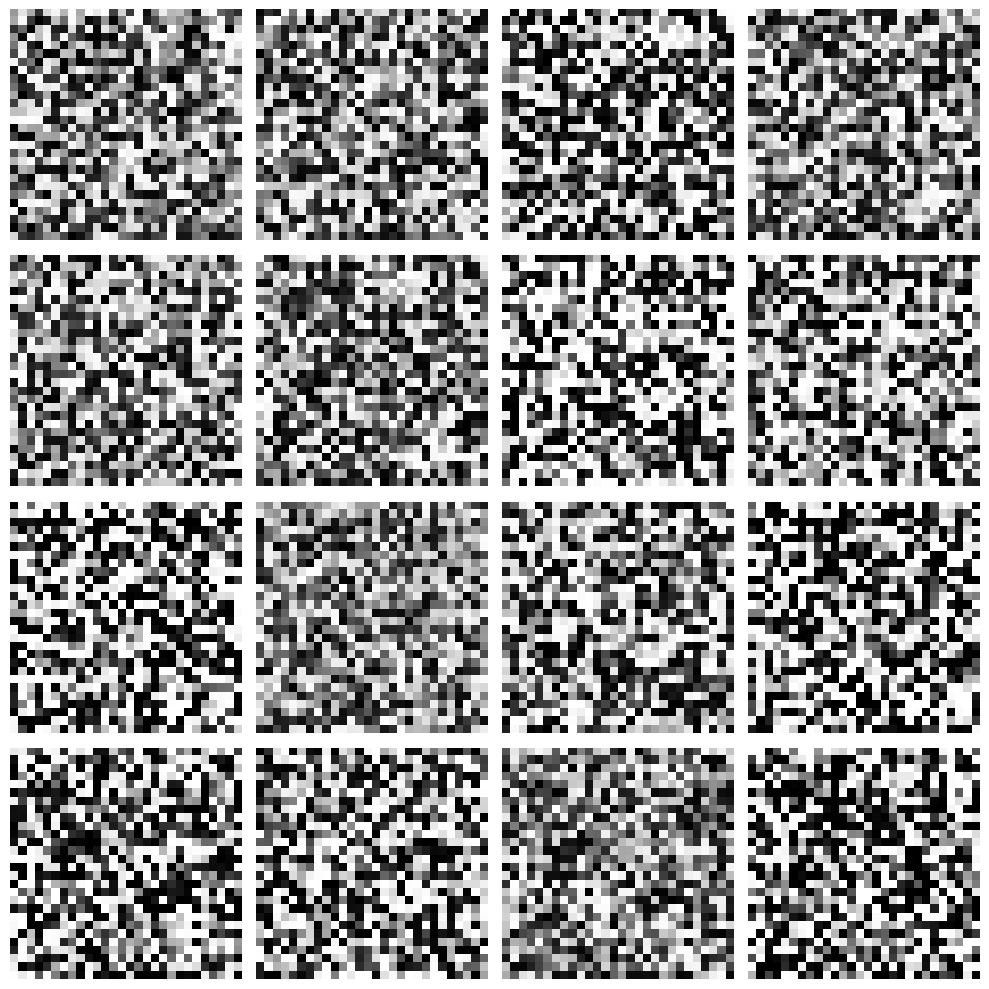

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

In [ ]:
train_gan(epochs=10000, batch_size=128)